In [367]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np
from matplotlib import pyplot as plt
from pandas import DataFrame
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
%matplotlib inline

In [368]:
data = pd.read_csv("kickstarter_data.csv")
data['success_rate'] = data['pled'] / data['goal'] * 100
data.columns, data.shape

(Index(['Unnamed: 0', 'URL', 'pled', 'goal', 'date', 'period', 'status',
        'text_am', 'n_img', 'n_vid', 'n_pled_t', 'min_pled_t', 'max_pled_t',
        'mean_pled_t', 'step_pled_t', 'cr_time', 'backed', 'created', 'site',
        'rpg', 'platformer', 'shooter', 'fighting', 'survival', 'horror',
        'strategy', 'arcade', 'simulator', 'mmo', 'indie', 'action', 'quest',
        'adventure', 'mgp', 'cont', 'curr', 'succsess', 'is_site',
        'success_rate'],
       dtype='object'),
 (8421, 39))

In [369]:
data[data['goal'] < 5]['success_rate'].mean()

331540.3557309402

<AxesSubplot:>

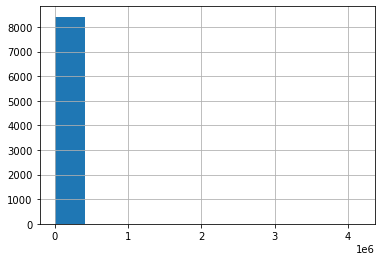

In [370]:
data['success_rate'].hist(bins=10)

In [371]:
df = data
if 'Unnamed: 0' in df.columns or 'succsess' in df.columns:
    df = data.drop(columns=['Unnamed: 0', 'succsess'])
df.shape

(8421, 37)

In [372]:
df.isnull().sum()

URL                0
pled               0
goal               0
date               0
period             0
status             0
text_am            0
n_img              0
n_vid              0
n_pled_t           0
min_pled_t         0
max_pled_t         0
mean_pled_t        0
step_pled_t        0
cr_time            0
backed             0
created            0
site            2471
rpg                0
platformer         0
shooter            0
fighting           0
survival           0
horror             0
strategy           0
arcade             0
simulator          0
mmo                0
indie              0
action             0
quest              0
adventure          0
mgp                0
cont               0
curr               0
is_site            0
success_rate       0
dtype: int64

In [373]:
numeric_columns = ['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure',
  'is_site']
futures = ['text_am', 'n_img', 'n_vid', 'cont', 'mgp', 'n_pled_t']
target_column = 'success_rate'
numeric_columns, target_column

(['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont'],
 'success_rate')

In [374]:
def draw_boxplots(df, numeric_columns):
    fig, axes = plt.subplots(4, 4, figsize=(18, 40))
    for i in range(2):
        for j in range(4):
            if 4 * i + j == len(numeric_columns):
                return
            axes[i, j].boxplot(df[numeric_columns[4 * i + j]], labels=[numeric_columns[4 * i + j]]) 

In [375]:
def draw_hist(df, features, var_labels, bar_type=None, n_bins=10):
    bar_type = 'bar' if bar_type == None else bar_type
    for col in features:
        plt.figure(figsize=(14, 10))
        plt.hist(df[col], histtype=bar_type, bins=n_bins, color='#BF2D00')
        plt.xlabel(var_labels[col], size=20)
        plt.ylabel(f'Количество проектов', size=20)

In [376]:
def draw_scatter(df, col):
    plt.figure(figsize=(14, 10))
    plt.scatter(df.sort_values(by=[col])[col], df.sort_values(by=[col])['success_rate'], c='#BF2D00')
    plt.xlabel(f'Значение переменной {col}, в ед.', fontsize=20)
    plt.ylabel(f'Значение success_rate, в %.', fontsize=20)

In [377]:
def del_n_sigmas_emissions(df, col_name, n_sigmas=3) -> DataFrame:
    len_was = df.shape[0]
    std = df[col_name].std()
    mean = df[col_name].mean()
    result = df[(df[col_name] >= mean - std * n_sigmas) & (df[col_name] <= mean + std * n_sigmas)]
    print(f'{col_name}: {len_was - result.shape[0]} lines deleted')
    return result    

<BarContainer object of 14 artists>

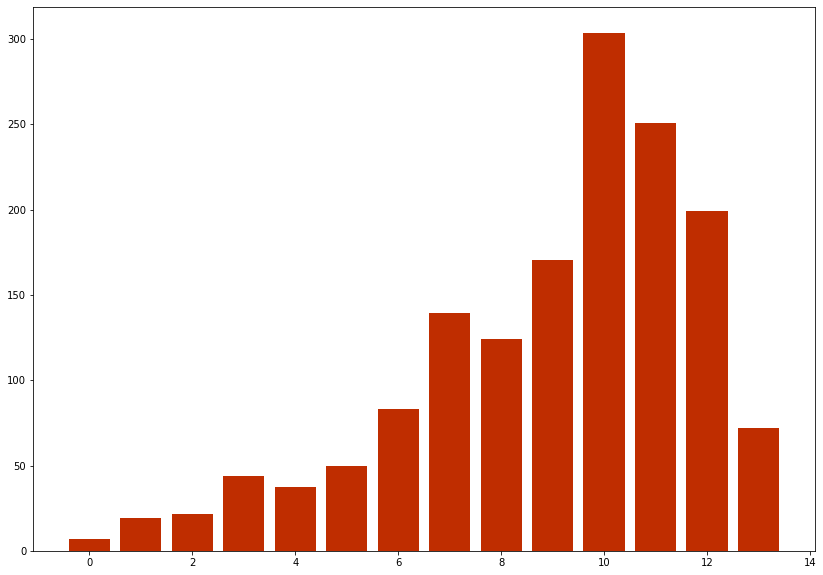

In [378]:
df = pd.read_csv("kickstarter_data.csv")
df['success_rate'] = data['pled'] / data['goal'] * 100


xs, ys = [], []
# Remove emissions
for val in df['created'].unique():
    vars_ = df[df['created'] == val]
    xs.append(val)
    ys.append(vars_['success_rate'].median())


plt.figure(figsize=(14, 10))
plt.bar(xs, ys, color='#BF2D00')

Shape was: 8421
created: 179 lines deleted
n_pled_t: 91 lines deleted
goal: 67 lines deleted
period: 43 lines deleted
goal < 15: 26
success_rate: 84 lines deleted
mgp: 138 lines deleted
n_img: 101 lines deleted
text_am: 138 lines deleted


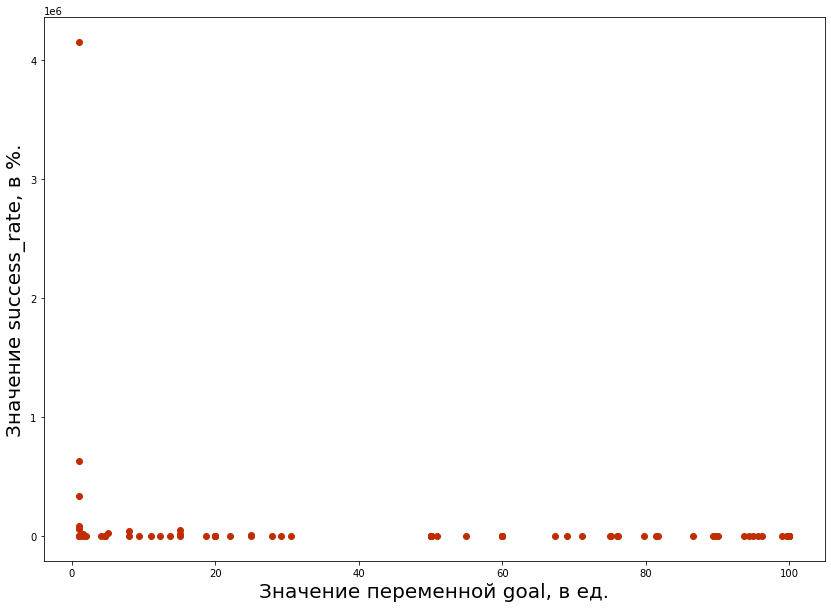

In [379]:
def get_prerocessed_data():
    df = pd.read_csv("kickstarter_data.csv")
    df['success_rate'] = data['pled'] / data['goal'] * 100
    
    # Remove emissions
    df['site'].fillna('', inplace=True)

    print(f'Shape was: {df.shape[0]}')
    # Using 3 sigmas rule
    df = del_n_sigmas_emissions(df, 'created')
    df = del_n_sigmas_emissions(df, 'n_pled_t')
    df = del_n_sigmas_emissions(df, 'goal') # Probably remove < 5.0 projects too
    df = del_n_sigmas_emissions(df, 'period')
    draw_scatter(df.sort_values(by=['goal']).iloc[0:df.shape[0] // 100], 'goal')
    len_was = df.shape[0]
    df = df[df['goal'] > 15]
    print('goal < 15:', len_was - df.shape[0])
    df = del_n_sigmas_emissions(df, 'success_rate')
    df = del_n_sigmas_emissions(df, 'mgp')
    df = del_n_sigmas_emissions(df, 'n_img')
    df = del_n_sigmas_emissions(df, 'text_am') 
    
    return df 

df = get_prerocessed_data()

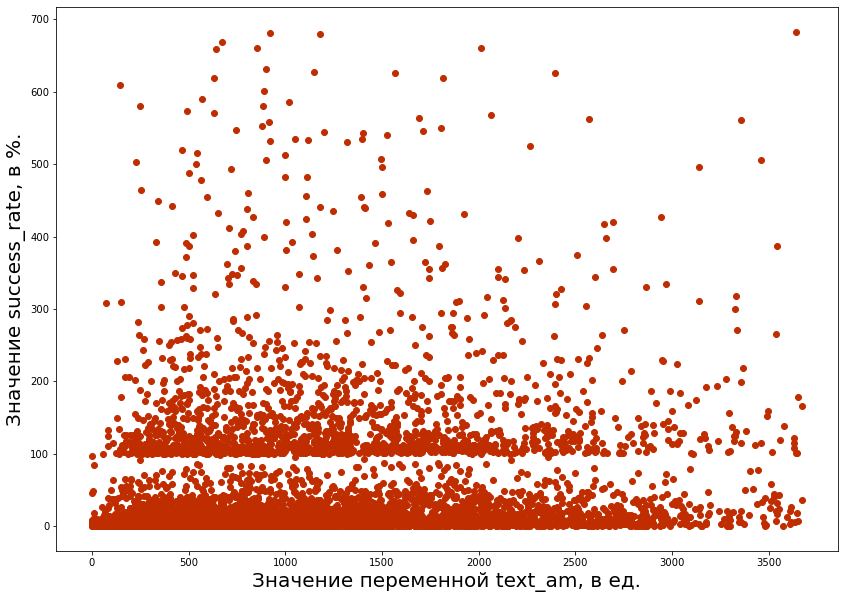

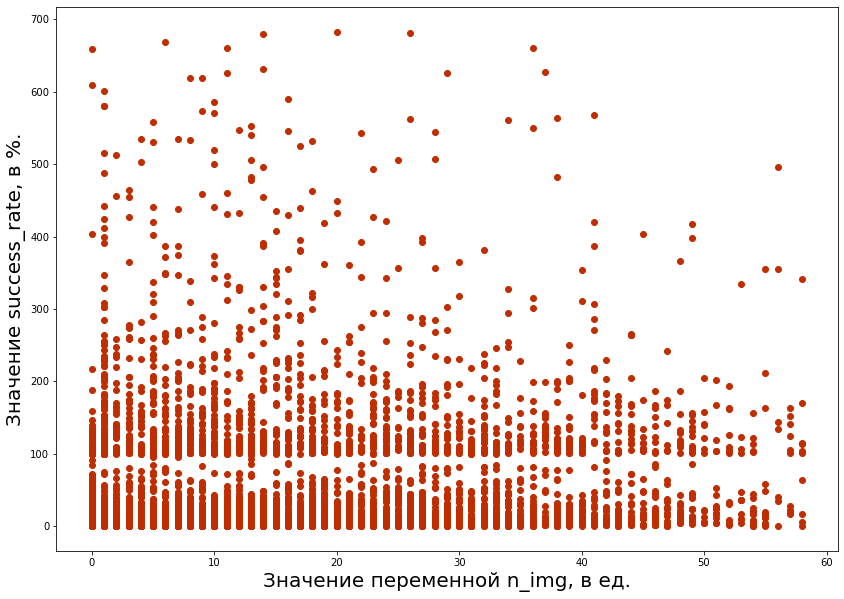

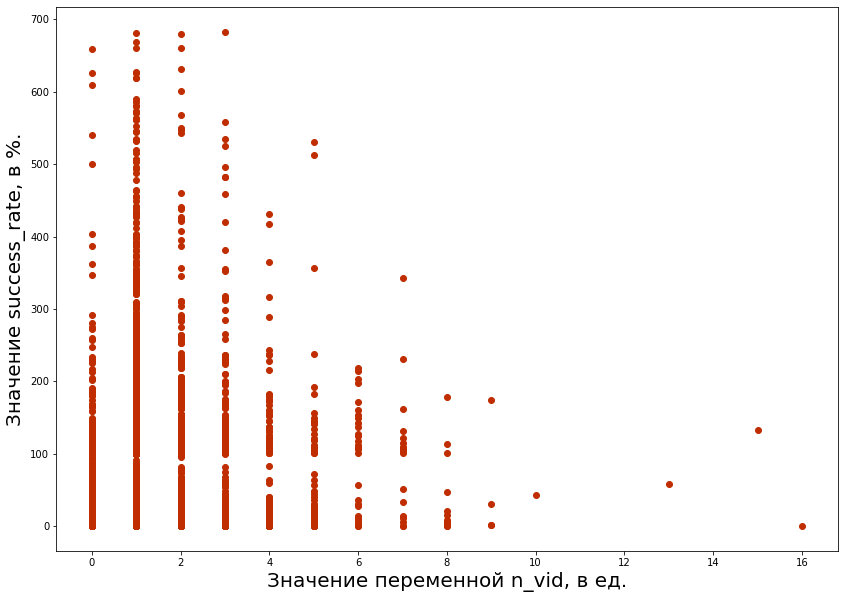

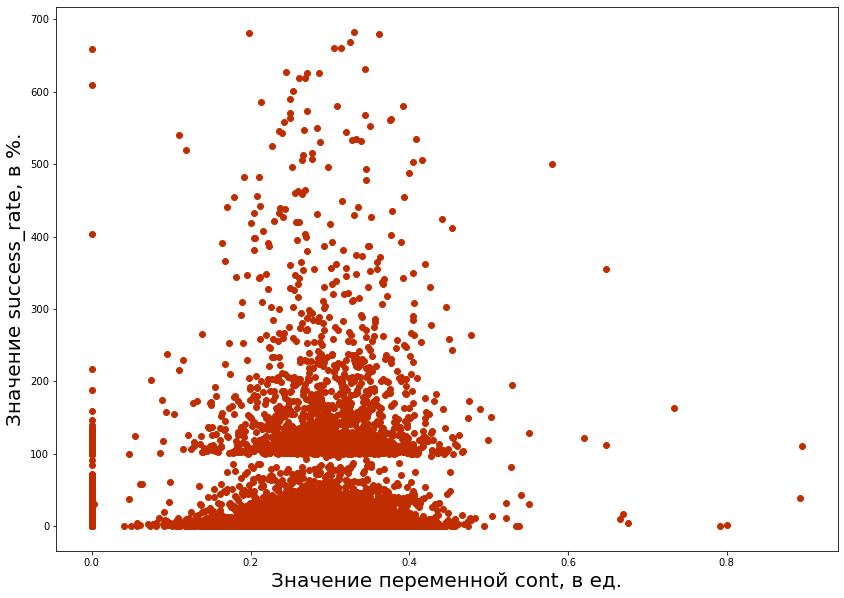

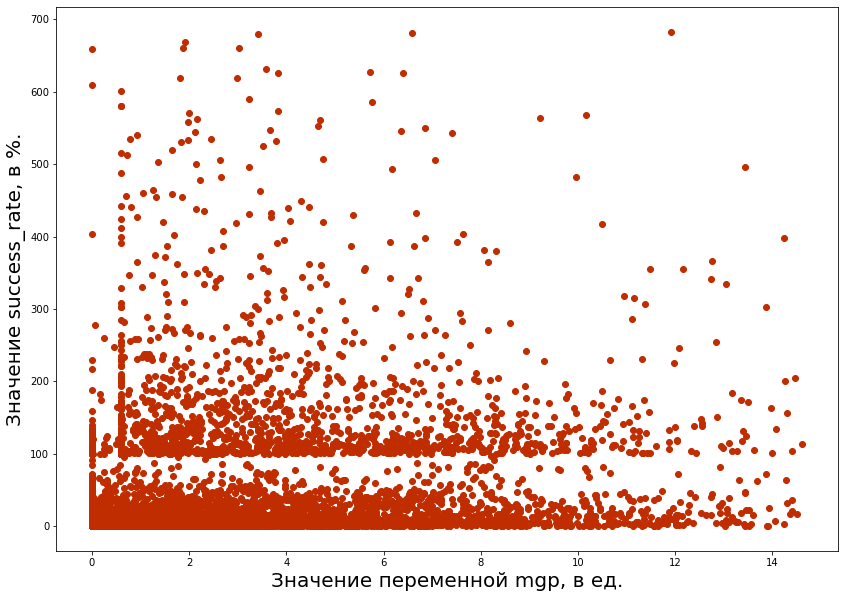

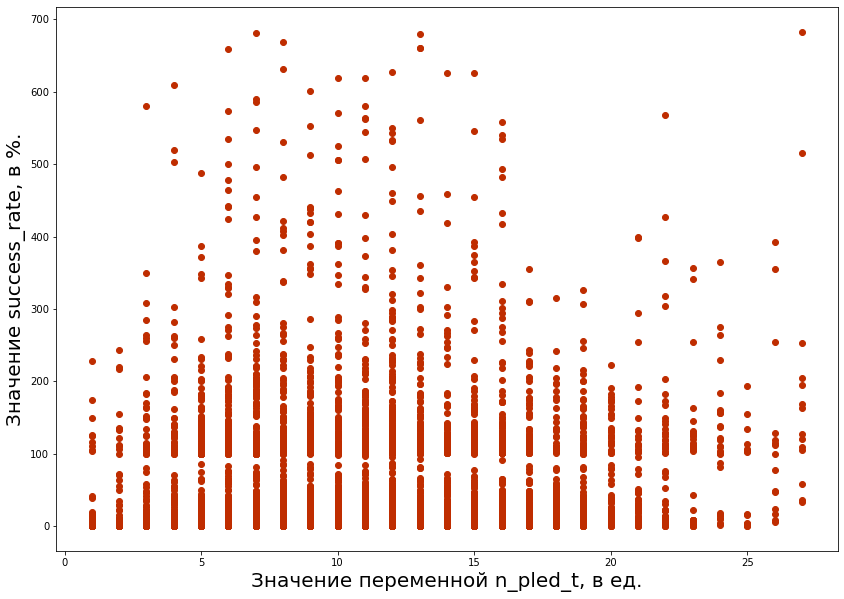

In [380]:
for col in futures:
    draw_scatter(df, col)

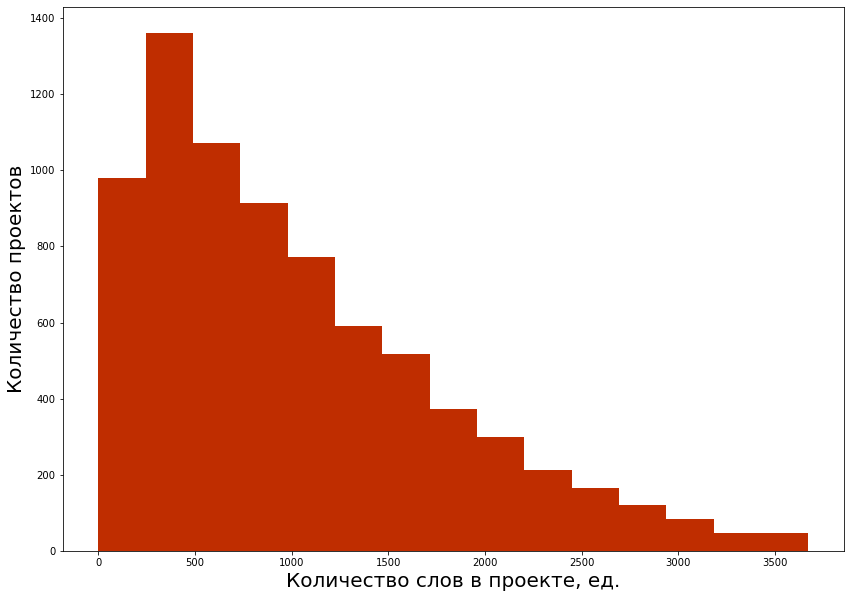

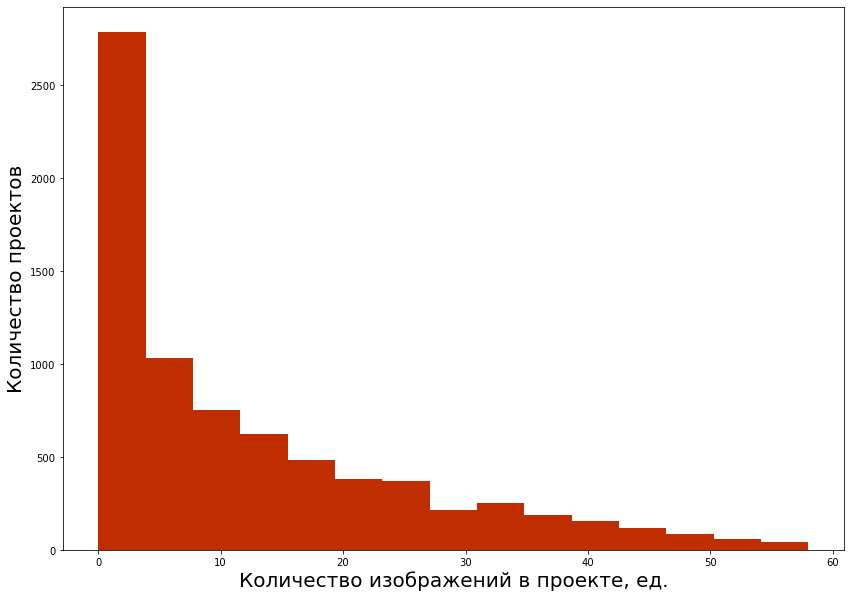

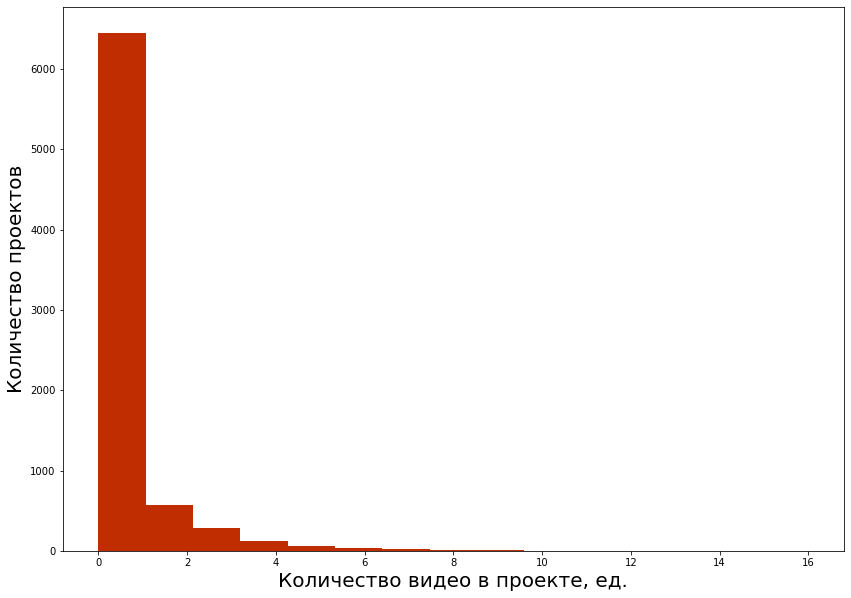

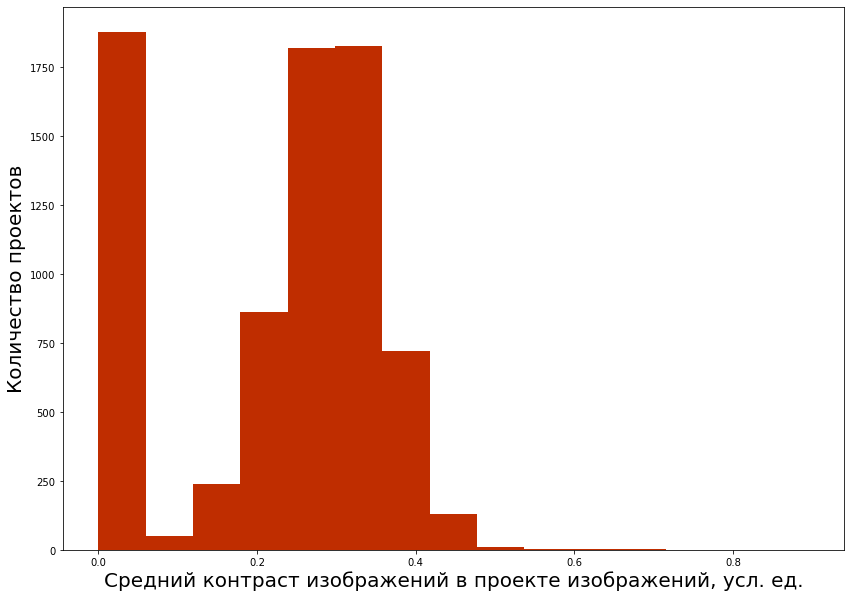

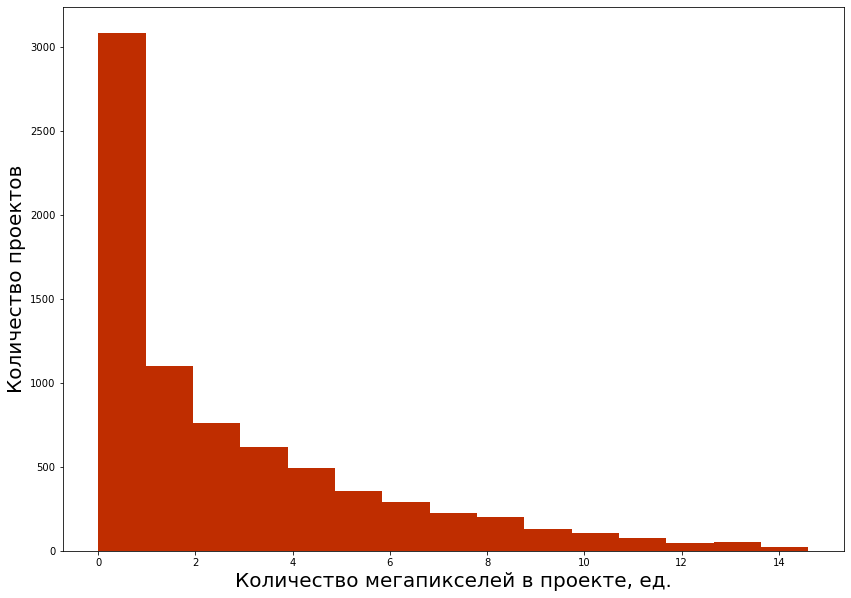

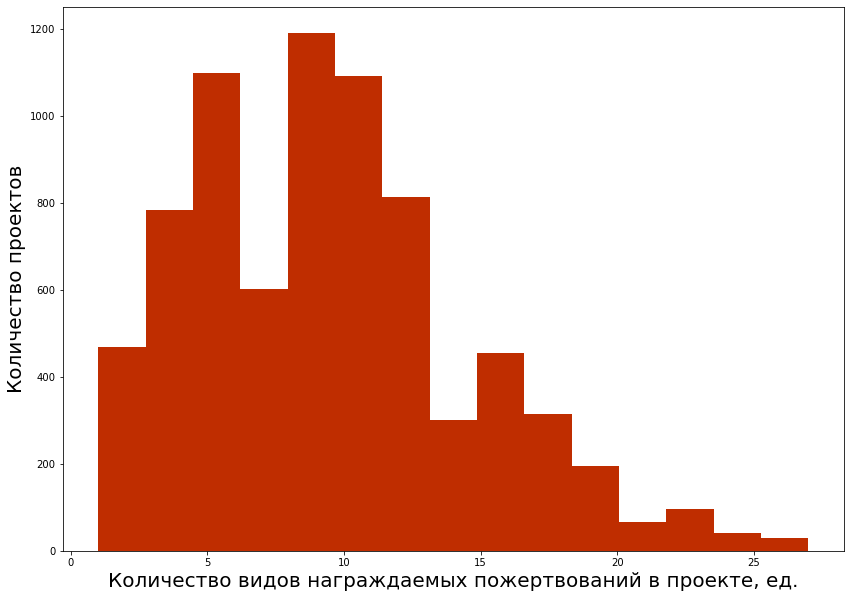

In [389]:
draw_hist(df, futures, {
    'n_img': 'Количество изображений в проекте, ед.',
    'n_vid': 'Количество видео в проекте, ед.',
    'n_pled_t': 'Количество видов награждаемых пожертвований в проекте, ед.',
    'cont': 'Средний контраст изображений в проекте изображений, усл. ед.',
    'mgp': 'Количество мегапикселей в проекте, ед.',
    'text_am': 'Количество слов в проекте, ед.',
    'period': 'Длительность периода сбора средств, дн.'}, n_bins=15)

In [390]:
# Descriptive statistics
desc = df[futures].describe()
desc.loc[:'count'] = desc.loc[:'count'].astype(np.int64)
desc.append(pd.Series(df[futures].median(), index=futures, name='median'))
desc

,text_am,n_img,n_vid,cont,mgp,n_pled_t
count,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000
mean,1015.454858,12.146015,0.657930,0.220436,2.650895,9.441488
std,763.081347,13.455981,1.185222,0.140349,3.044011,5.074066
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,400.000000,1.000000,0.000000,0.089308,0.046310,6.000000
50%,820.000000,7.000000,0.000000,0.266542,1.570555,9.000000
75%,1457.000000,19.000000,1.000000,0.321910,4.086018,12.000000
max,3673.000000,58.000000,16.000000,0.894847,14.609122,27.000000


In [391]:
pd.DataFrame(df.corr()['success_rate'][futures])

,success_rate
text_am,0.209963
n_img,0.222975
n_vid,0.333324
cont,0.237953
mgp,0.235407
n_pled_t,0.212593


In [392]:
def draw_dependencies(df, features):
    rows = 2
    cols = 4
    plt.subplots_adjust(wspace=0.6, hspace=0.3)
    fig, axes = plt.subplots(rows, cols, figsize=(36, 18))
    for i in range(rows):
        for j in range(cols):
            if cols * i + j == len(features):
                return
            
            col = features[cols * i + j]
            xs = []
            ys = []

            if col == 'text_am':
                n_texts = []
                step = 200
                for v in range(1, df['text_am'].max(), step):
                    s = df[(df['text_am'] >= v) & (df['text_am'] < v + step)]['success_rate']
                    if s.shape[0] > 5: 
                        n_texts.append((f'{int((2 * v + step) / 2)}', v, s.sum() / s.shape[0]))

                n_texts = sorted(n_texts, key=lambda x: x[1])

                xs = [k for title, k, v in n_texts]
                ys = [v for title, k, v in n_texts]
            elif col == 'cont':
                n_conts = []
                step = 0.05
                for v in np.arange(0, df['cont'].max(), step):
                    s = df[(df['cont'] >= v) & (df['cont'] < v + step)]['cont']
                    if s.shape[0] > 2: 
                        n_conts.append((f'{(2 * v + step) / 2}', v, s.sum() / s.shape[0]))

                n_conts = sorted(n_conts, key=lambda x: x[1])

                xs = [k for title, k, v in n_conts]
                ys = [v for title, k, v in n_conts]
            else:
                for val in sorted(df[col].unique()):
                    mean_sr = df[df[col] == val]['success_rate'].mean()
                    if df[df[col] == val].shape[0] > 5:
                        xs.append(val)
                        ys.append(mean_sr)

            axes[i, j].plot(xs, ys)
            axes[i, j].set_xlabel(f'Значение переменной {features[4 * i + j]}', size=14)
            axes[i, j].set_ylabel(f'Значение переменной success_rate', size=14)

In [393]:
def split_array_by_parts(array_len, n_splits):
    """
    Returns indices for split parts
    """
    step = 0
    if array_len % n_splits == 0:
        step = array_len // n_splits
    else:
        step = array_len // n_splits + 1
    i = 0
    result = []
    while i < array_len:
        result.append((i, min(i + step, array_len)))
        i += step
    return result


def draw_dep(df, cols, n_intervals, var_labels):
    step = 1.0 / n_intervals
    
    indices = split_array_by_parts(df.shape[0], n_intervals)
    
    for col in cols:
        plt.figure(figsize=(14, 10))
        plot_vals = {}
        repeats = {}
        xs = []
        ys = []

        sorted_df = df.sort_values(by=[col])
        for start, stop in indices:
            cur_vals = sorted_df.iloc[start : stop]
            col_median = cur_vals[col].median()
            s_r_mean = cur_vals['success_rate'].mean()
            
            if col == 'cont':
                col_median = cur_vals[col].mean()

            xs.append(col_median)
            ys.append(s_r_mean)
        new_xs, new_ys = [], []
        reps = {}
        vals = {}
        for x, y in zip(xs, ys):
            if x not in reps:
                reps[x] = 0
                vals[x] = []
            reps[x] += 1
            vals[x].append(y)
        for x, n_reps in reps.items():
            new_ys.append(sum(vals[x]) / n_reps)
            es = 0
            if col == 'text_am':
                x /= 100
            new_xs.append(float(f'{x:.2f}'))
            
            
        bar_width = 0.2 if col == 'cont' else 0.8
        plt.bar(new_xs, new_ys, color='#BF2D00', width=bar_width)
        left, right = plt.xlim()
        
        plt.xlim(0, right)
        plt.xlabel(var_labels[col], fontsize=20)
        plt.ylabel(f'Среднее отношение собраных средств к цели, в %.', fontsize=20)            

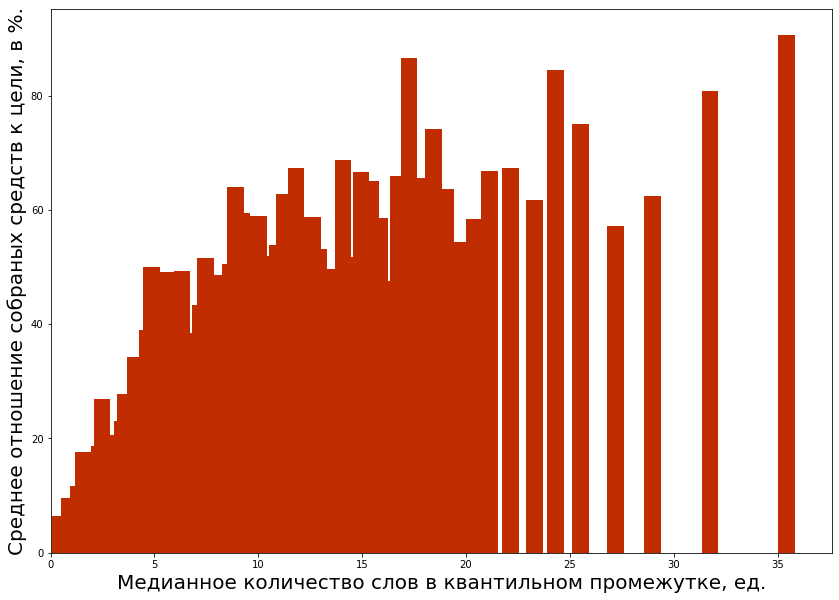

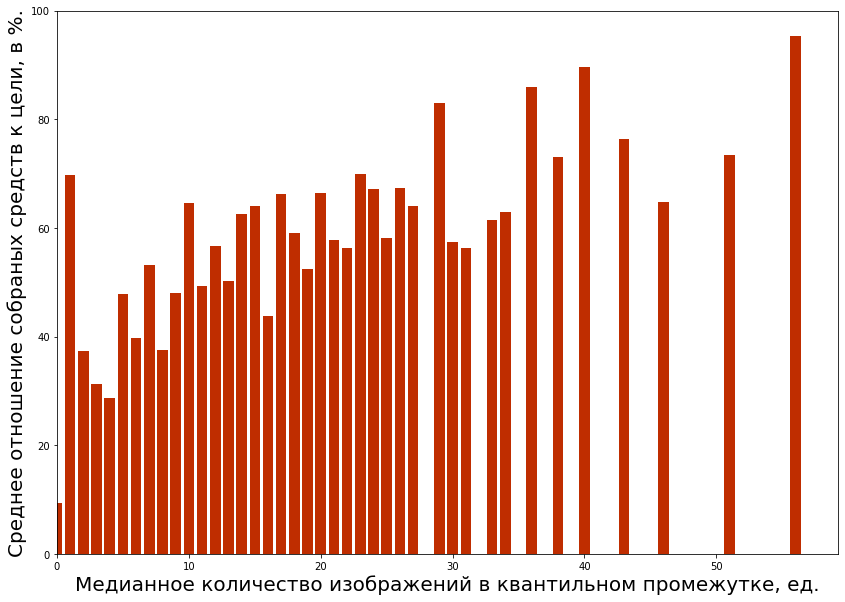

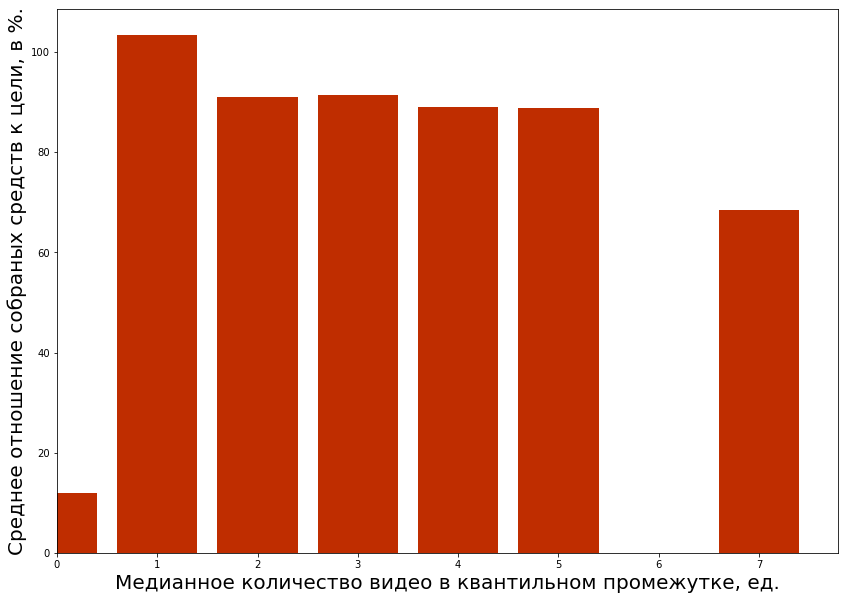

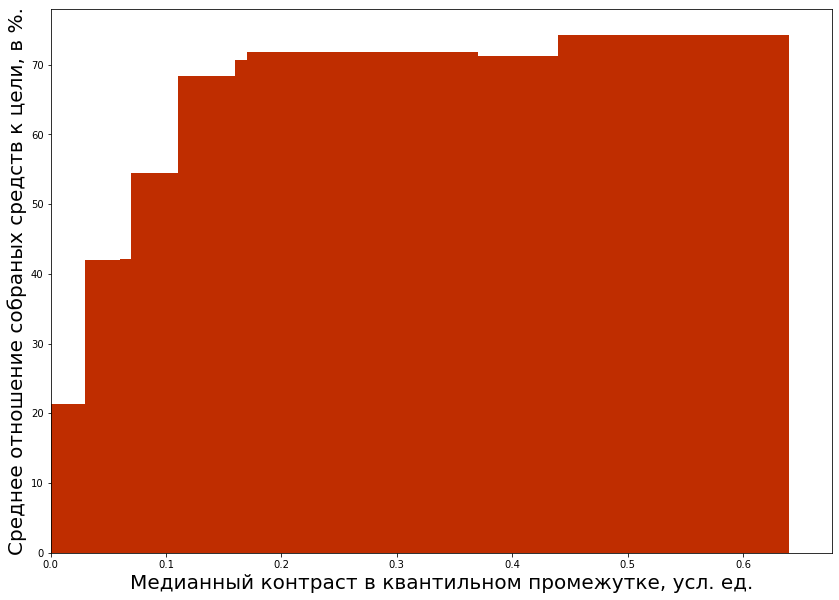

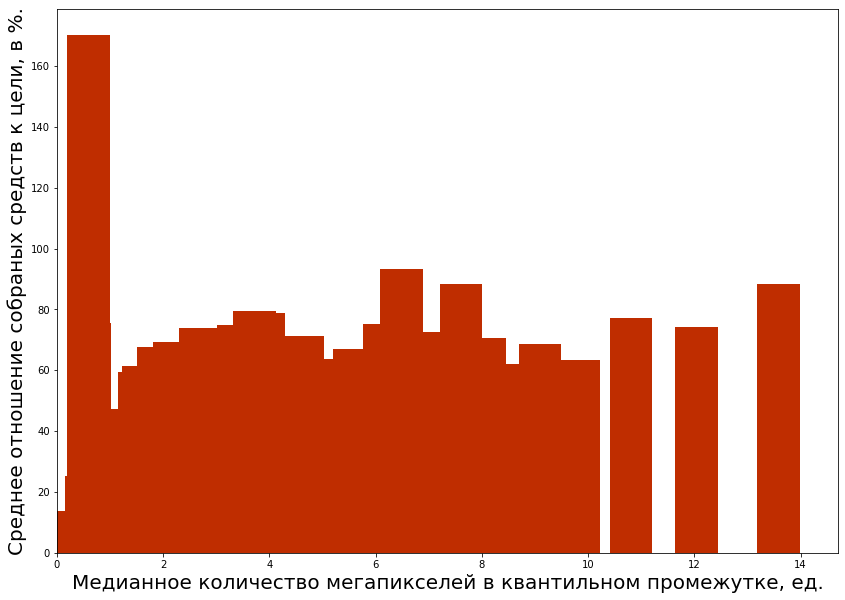

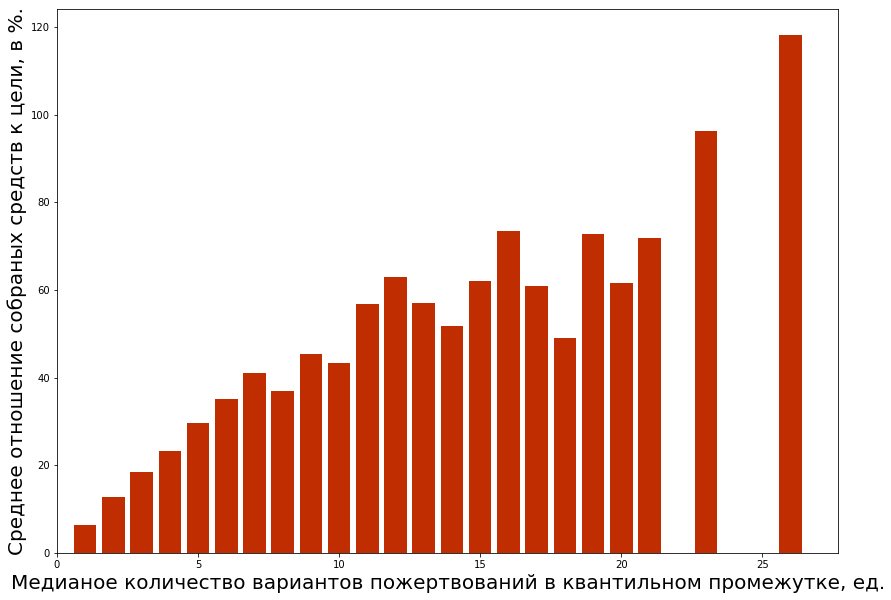

In [394]:
# draw_dependencies(df, futures)
draw_dep(df, futures, 80,
        {'n_img': 'Медианное количество изображений в квантильном промежутке, ед.',
         'n_vid': 'Медианное количество видео в квантильном промежутке, ед.',
         'mgp': 'Медианное количество мегапикселей в квантильном промежутке, ед.',
         'cont': 'Медианный контраст в квантильном промежутке, усл. ед.',
         'n_pled_t': 'Медианое количество вариантов пожертвований в квантильном промежутке, ед.',
         'text_am': 'Медианное количество слов в квантильном промежутке, ед.'})

(8421, 39)


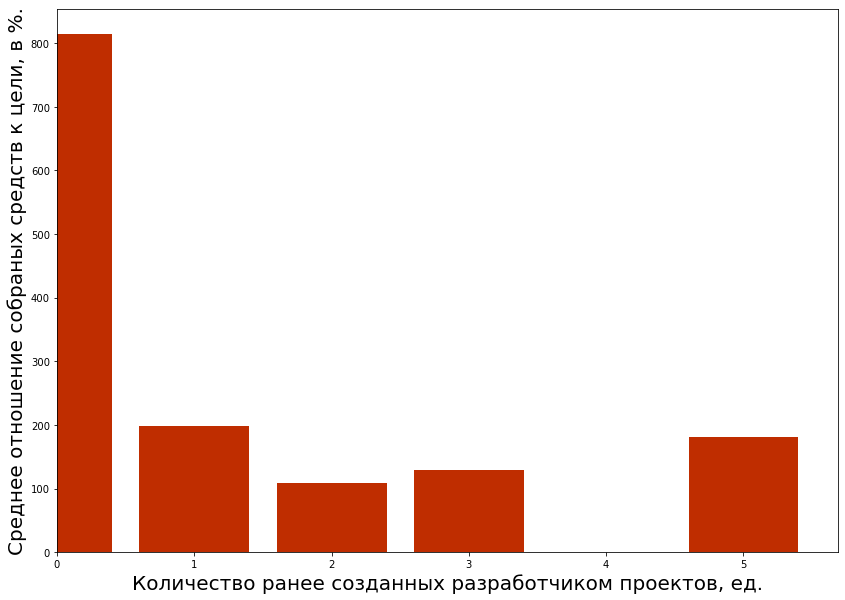

In [395]:
print(data.shape)
draw_dep(data, ['created'], 60, {'created': 'Количество ранее созданных разработчиком проектов, ед.'})

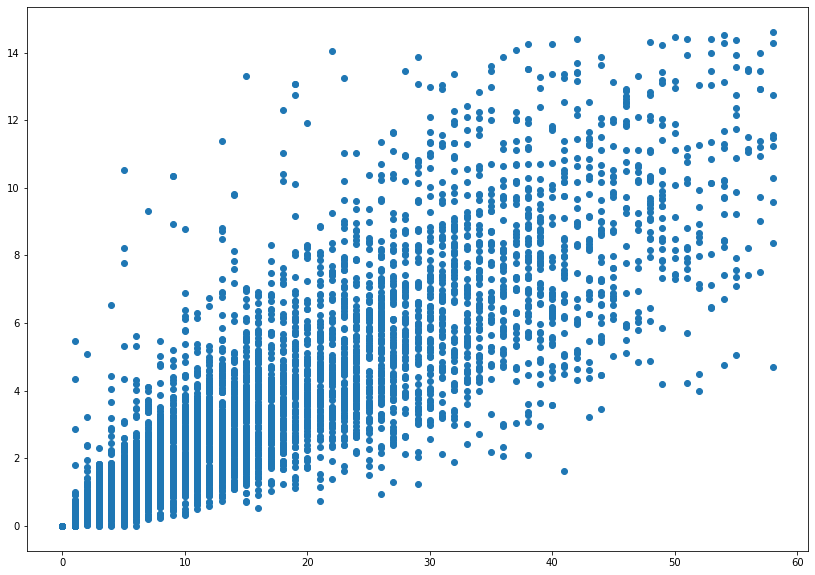

In [396]:
plt.figure(figsize=(14, 10))
plt.scatter(df['n_img'], df['mgp'])

In [397]:
# Linear models
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np

In [398]:
numeric_columns = [
#   'pled',
  'goal',
  'period',
  'text_am',
#   'n_img', # VIF
  'n_vid',
  'n_pled_t',
#   'min_pled_t', # P-val
#   'max_pled_t', # VIF
#   'mean_pled_t', # VIF
  'step_pled_t', # P-val
#   'cr_time', # p-val
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = ['rpg',
#   'platformer', # p-val
  'shooter',
#   'fighting', # p-val
#   'survival', # p-val
  'horror',
  'strategy',
#   'arcade', # p-val
#   'simulator', # p-val
  'mmo',
  'indie',
  'action',
#   'quest', # p-val
#   'adventure', # p-val
  'is_site']
futures = ['text_am', 'n_vid', 'cont',
           'mgp', # 'n_img',
           'n_pled_t']
columns = numeric_columns + binary_columns

In [399]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


vif = pd.DataFrame()
vif_data = pd.DataFrame()
vif_data["feature"] = df[columns].columns
vif_data["VIF"] = [variance_inflation_factor(df[columns].values, i)
                          for i in range(len(df[columns].columns))]
vif_data

,feature,VIF
0,goal,1.406778
1,period,4.354519
2,text_am,5.693226
3,n_vid,1.592882
4,n_pled_t,7.740634
5,step_pled_t,1.548375
6,backed,1.204336
7,created,1.180591
8,mgp,3.302449
9,cont,4.298279


In [414]:
inp = df[columns].assign(bias=np.ones((df.shape[0])))
square_columns = []
for col in ['text_am']:
    inp[f'{col}_sqr'] = inp[col] ** 2
    square_columns.append(f'{col}_sqr')

ols = sm.OLS(df['success_rate'], inp)
res = ols.fit()

results_as_html = res.summary().tables[1].as_html()
summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           success_rate   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     87.95
Date:                Fri, 17 Dec 2021   Prob (F-statistic):          2.02e-309
Time:                        15:33:20   Log-Likelihood:                -43279.
No. Observations:                7554   AIC:                         8.660e+04
Df Residuals:                    7534   BIC:                         8.674e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
goal           -0.0001   1.13e-05    -10.317      0.000      -0.000   -9.48e-05
period         -0.2331      0.086     -2.723      0.006      -0.401      -0.065
text_am         0.0101      0.004      2.368      0.018       0.002       0.018
n_vid          17.6594      0.799     22.091      0.000      16.092      19.226
n_pled_t        1.0293      0.232      4.441      0.000       0.575       1.484
step_pled_t    -0.0092      0.002     -3.941      0.000      -0.014      -0.005
backed          0.3248      0.090      3.610      0.000       0.148       0.501
created         8.9919      1.977      4.548      0.000       5.116      12.867
mgp             1.3503      0.390      3.461      0.001       0.585       2.115
cont           58.3480      7.346      7.943      0.000      43.948      72.748
rpg            10.9617      2.191      5.003      0.000       6.667      15.257
shooter       -12.1505      3.033     -4.006      0.000     -18.097      -6.204
horror         -8.2886      3.429     -2.417      0.016     -15.011      -1.566
strategy       -7.5821      2.543     -2.981      0.003     -12.567      -2.597
mmo           -14.7923      3.604     -4.105      0.000     -21.856      -7.728
indie           5.5571      2.151      2.583      0.010       1.340       9.774
action        -10.5499      2.103     -5.017      0.000     -14.672      -6.428
is_site         5.8449      2.015      2.900      0.004       1.894       9.796
bias            9.4672      3.917      2.417      0.016       1.788      17.146
text_am_sqr -1.817e-06    1.3e-06     -1.400      0.161   -4.36e-06    7.26e-07
==============================================================================
Omnibus:                     5483.836   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           106923.695
Skew:                           3.316   Prob(JB):                         0.00
Kurtosis:                      20.196   Cond. No.                     2.40e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:>

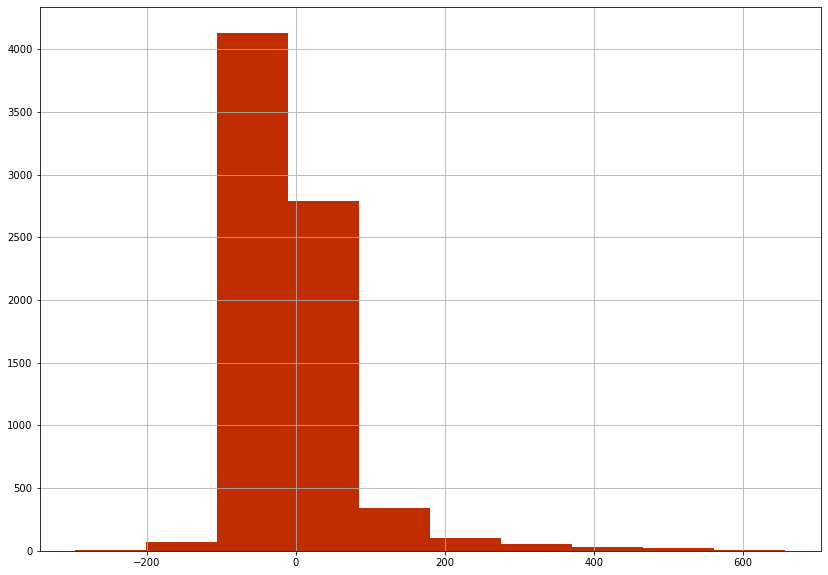

In [415]:
plt.figure(figsize=(14, 10))
res.resid.hist(color='#BF2D00')

In [416]:
def draw_lines_on_plot(df, col, coeffs, bias):
    plt.figure(figsize=(14, 10))
    def func(x):
        res = bias
        for i in range(len(coeffs)):
            res += coeffs[i] * x ** (len(coeffs) - i)
        return res
    plt.plot(df.sort_values(by=[col])[col], func(df.sort_values(by=[col])[col]), c='red')
    plt.scatter(df.sort_values(by=[col])[col], df.sort_values(by=[col])['success_rate'])

text_am y=-1.817e-06x^2 + 0.0101x + 9.4672 Xв=2779.306549257017


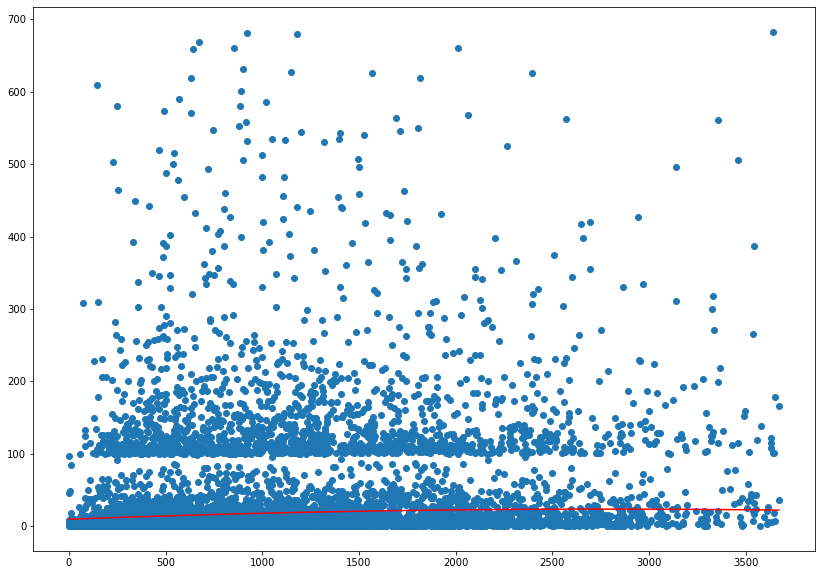

In [417]:
for col in ['text_am']:
    draw_lines_on_plot(inp.assign(success_rate=df['success_rate']),
                       col, [summary_df['coef'][f'{col}_sqr'], summary_df['coef'][col]], summary_df['coef']['bias'])
    a = summary_df["coef"][f"{col}_sqr"]
    b = summary_df["coef"][col]
    c = summary_df["coef"]["bias"]
    print(col, f'y={a}x^2 + {b}x + {c}', f'Xв={-b/(2*a)}')

In [410]:
# Cascade Adj. r^2 check
inp = df[columns]  # .assign(bias=np.ones((df.shape[0])))
ols = sm.OLS(df['success_rate'], inp)
res = ols.fit()

results_as_html = res.summary().tables[1].as_html()
summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

r_2_origin = res.rsquared_adj

important_cols = list(summary_df.index)

for col in summary_df.index:
    col_copy = inp[col]
    inp = inp.drop(columns=[col])
    ols = sm.OLS(df['success_rate'], inp)
    res = ols.fit()
    new_r_2 = res.rsquared_adj
    
    if abs(new_r_2 - r_2_origin) / r_2_origin > 0.005:
            inp[col] = col_copy
    else:
        print('removed', col, (new_r_2 - r_2_origin) / r_2_origin)
        important_cols.remove(col)
print(important_cols)

removed period 0.00012405600810160223
removed text_am -0.0017676683655510942
removed step_pled_t -0.004763061035290934
['goal', 'n_vid', 'n_pled_t', 'backed', 'created', 'mgp', 'cont', 'rpg', 'shooter', 'horror', 'strategy', 'mmo', 'indie', 'action', 'is_site']


In [411]:
# Check log reg and log(linear reg)
linear = LinearRegression()
linear.fit(df[columns].assign(bias=np.ones(df.shape[0])), df['success_rate'])
preds1 = linear.predict(df[columns].assign(bias=np.ones(df.shape[0])))

r2_score(df['success_rate'], preds1)

# logreg = LogisticRegression(max_iter=1000)
# df['success'] = df['success_rate'].apply(lambda x: 1 if x >= 1 else 0) 
# logreg.fit(df[columns].assign(bias=np.ones(df.shape[0])), df['success'])
# preds2 = logreg.predict_proba(df[columns].assign(bias=np.ones(df.shape[0])))
# r2_score(df['success_rate'], preds2[:, 1])

0.18131923724263732